# Movie Insights Analytics Pipeline 

## Setting up the environment

In [1]:
import pymysql

# Database connection settings
db_settings = {
    "host": "localhost",  
    "user": "root",  
    "password": "Abc@1234",  
    "database": "moviesdb",
}

# Create connection
conn = pymysql.connect(**db_settings)

# Create a cursor to execute SQL queries
cursor = conn.cursor()


## Check the connection

In [2]:
try:
    cursor.execute("SELECT DATABASE();")
    print("Connected to Database:", cursor.fetchone())
except Exception as e:
    print("Error in database connection:", e)
finally:
    cursor.close()
    conn.close()

Connected to Database: ('moviesdb',)


## Extract and Load the data to Database

In [3]:
import pandas as pd
import pymysql
import warnings

warnings.filterwarnings("ignore", category=UserWarning)

# Establish connection
conn = pymysql.connect(**db_settings)
cursor = conn.cursor()

### Load data from CSV file

In [4]:
movies_df = pd.read_csv('C:\\Users\\LENOVO\\Desktop\\Movie_data\\movies.csv')
ratings_df = pd.read_csv('C:\\Users\\LENOVO\\Desktop\\Movie_data\\ratings.csv')
tags_df = pd.read_csv('C:\\Users\\LENOVO\\Desktop\\Movie_data\\tags.csv')
links_df = pd.read_csv('C:\\Users\\LENOVO\\Desktop\\Movie_data\\links.csv')

### Insert data into Database

In [5]:
# Insert movies into MySQL
for index, row in movies_df.iterrows():
    cursor.execute("INSERT IGNORE INTO movies (movieId, title, genres) VALUES (%s, %s, %s)",
                   (row['movieId'], row['title'], row['genres']))

# Insert ratings into MySQL
for index, row in ratings_df.iterrows():
    cursor.execute("INSERT IGNORE INTO ratings (userId, movieId, rating, timestamp) VALUES (%s, %s, %s, %s)",
                   (row['userId'], row['movieId'], row['rating'], row['timestamp']))

# Insert tags into MySQL
for index, row in tags_df.iterrows():
    cursor.execute("INSERT IGNORE INTO tags (userId, movieId, tag, timestamp) VALUES (%s, %s, %s, %s)",
                   (row['userId'], row['movieId'], row['tag'], row['timestamp']))

# Insert links into MySQL
for index, row in links_df.iterrows():
    cursor.execute("INSERT IGNORE INTO links (movieId, imdbId, tmdbId) VALUES (%s, %s, %s)",
                   (row['movieId'], row['imdbId'], row['tmdbId']))

conn.commit()

# Close the cursor and connection
cursor.close()
conn.close()

print("Data has been loaded into MySQL tables successfully!")

Data has been loaded into MySQL tables successfully!


## Transform and Preprocess the data

### Check the loaded data

In [6]:
conn = pymysql.connect(**db_settings)

# Query raw data into pandas DataFrames
movies_df = pd.read_sql("SELECT * FROM movies", conn)
ratings_df = pd.read_sql("SELECT * FROM ratings", conn)
tags_df = pd.read_sql("SELECT * FROM tags", conn)
links_df = pd.read_sql("SELECT * FROM links", conn)

# Close the connection after extraction
conn.close()

# Display the first few rows of the data to ensure extraction worked
print("Movies Data:")
print(movies_df.head())
print("\nRatings Data:")
print(ratings_df.head())
print("\nTags Data:")
print(tags_df.head())
print("\nLinks Data:")
print(links_df.head())

Movies Data:
   movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy  

Ratings Data:
   id  userId  movieId  rating  timestamp
0   1       1        1     4.0  964982703
1   2       1        3     4.0  964981247
2   3       1        6     4.0  964982224
3   4       1       47     5.0  964983815
4   5       1       50     5.0  964982931

Tags Data:
   id  userId  movieId              tag   timestamp
0   1       2    60756            funny  1445714994
1   2    

### Clean the data

In [7]:
# Drop duplicates
movies_df.drop_duplicates(subset="movieId", inplace=True)
ratings_df.drop_duplicates(inplace=True)
tags_df.drop_duplicates(inplace=True)

# Handle invalid or null entries (e.g., null ratings or missing movieIds)
ratings_df.dropna(subset=["userId", "movieId", "rating"], inplace=True)
tags_df.dropna(subset=["movieId", "tag"], inplace=True)

# Remove outliers if necessary
ratings_df = ratings_df[ratings_df['rating'] >= 0]  # Remove any negative ratings
ratings_df = ratings_df[ratings_df['rating'] <= 10]  # Ensure ratings stay in a valid range

# Precompute user average ratings for aggregation insights
user_avg_ratings = ratings_df.groupby('userId')['rating'].mean().reset_index()
user_avg_ratings.rename(columns={"rating": "user_avg_rating"}, inplace=True)

# Check transformations
print("\nUser Average Ratings:")
print(user_avg_ratings.head())


User Average Ratings:
   userId  user_avg_rating
0       1         4.366379
1       2         3.948276
2       3         2.435897
3       4         3.555556
4       5         3.636364


### Load the transformed data back to MySQL

In [9]:
# Reconnect to the database for loading data back
conn = pymysql.connect(**db_settings)
cursor = conn.cursor()

# Insert the cleaned and aggregated user average ratings into MySQL
for index, row in user_avg_ratings.iterrows():
    cursor.execute(
        "INSERT IGNORE INTO user_avg_ratings (userId, user_avg_rating) VALUES (%s, %s)",
        (row['userId'], row['user_avg_rating'])
    )

# Commit changes to the database
conn.commit()

# Close the cursor and connection
cursor.close()
conn.close()

print("User average ratings have been transformed and loaded into MySQL!")

User average ratings have been transformed and loaded into MySQL!


## Analytics and Data Visualisation

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

In [11]:
# Set visualization style
sns.set(style="whitegrid")

In [12]:
# Establish database connection
conn = pymysql.connect(**db_settings)

### Top 10 movies by Average Ratings

In [13]:
query_top_movies_avg_rating = """
SELECT m.title, AVG(r.rating) AS avg_rating
FROM ratings r
JOIN movies m ON r.movieId = m.movieId
GROUP BY m.movieId
ORDER BY avg_rating DESC
LIMIT 10;
"""
top_movies_df = pd.read_sql(query_top_movies_avg_rating, conn)

Text(0, 0.5, 'Movie Title')

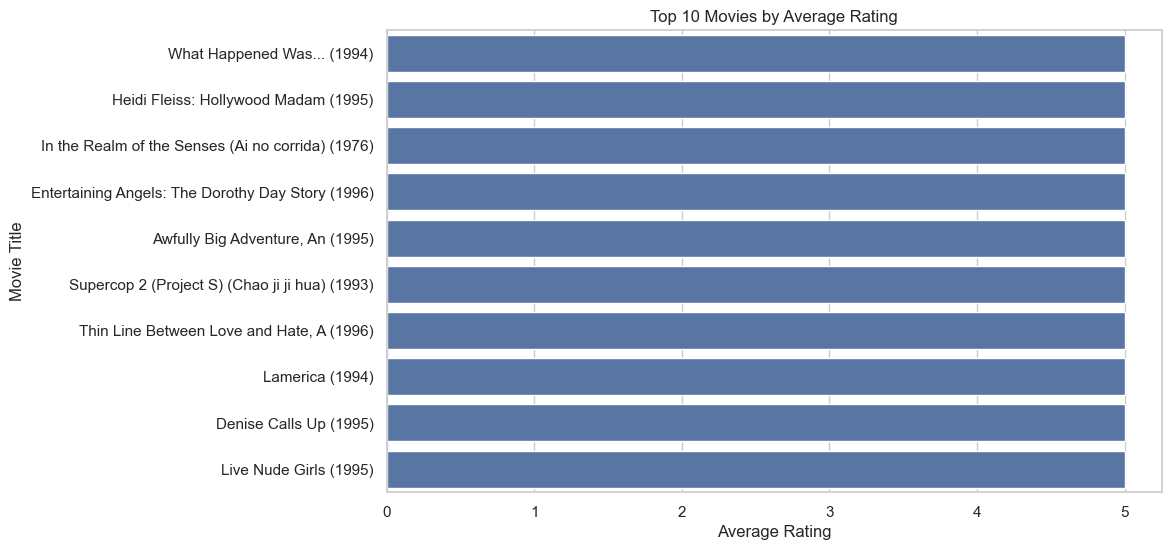

In [14]:
plt.figure(figsize=(10, 6))
sns.barplot(x='avg_rating', y='title', data=top_movies_df)
plt.title("Top 10 Movies by Average Rating")
plt.xlabel("Average Rating")
plt.ylabel("Movie Title")

### Most Active Users

Text(0, 0.5, 'No. of Ratings')

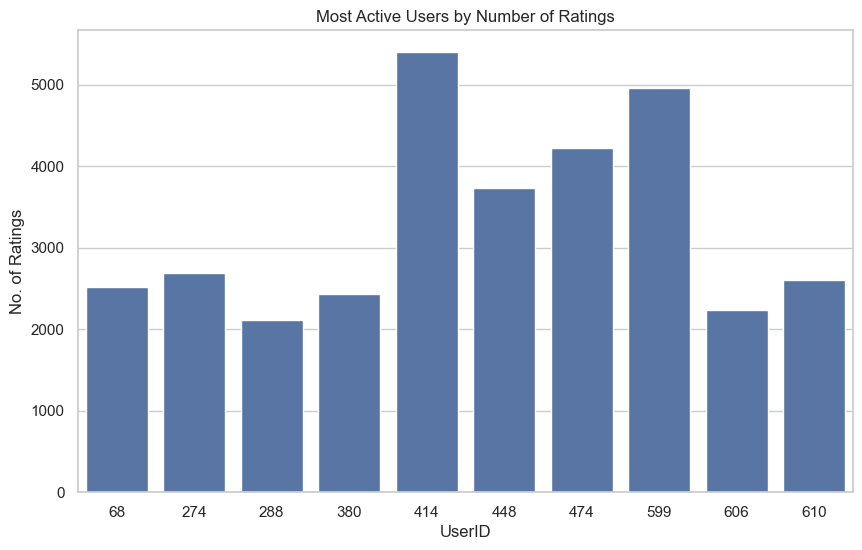

In [15]:
query_most_active_users = """
SELECT userId, COUNT(*) AS num_ratings
FROM ratings
GROUP BY userId
ORDER BY num_ratings DESC
LIMIT 10;
"""
most_active_users_df = pd.read_sql(query_most_active_users, conn)

plt.figure(figsize=(10, 6))
sns.barplot(y='num_ratings', x='userId', data=most_active_users_df)
plt.title("Most Active Users by Number of Ratings")
plt.xlabel("UserID")
plt.ylabel("No. of Ratings")

### Top Movies By Rating Count

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_8876\1627653908.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='num_ratings', y='title', data=top_movies_by_rating_count_df, palette="mako")


Text(0, 0.5, 'Movie Title')

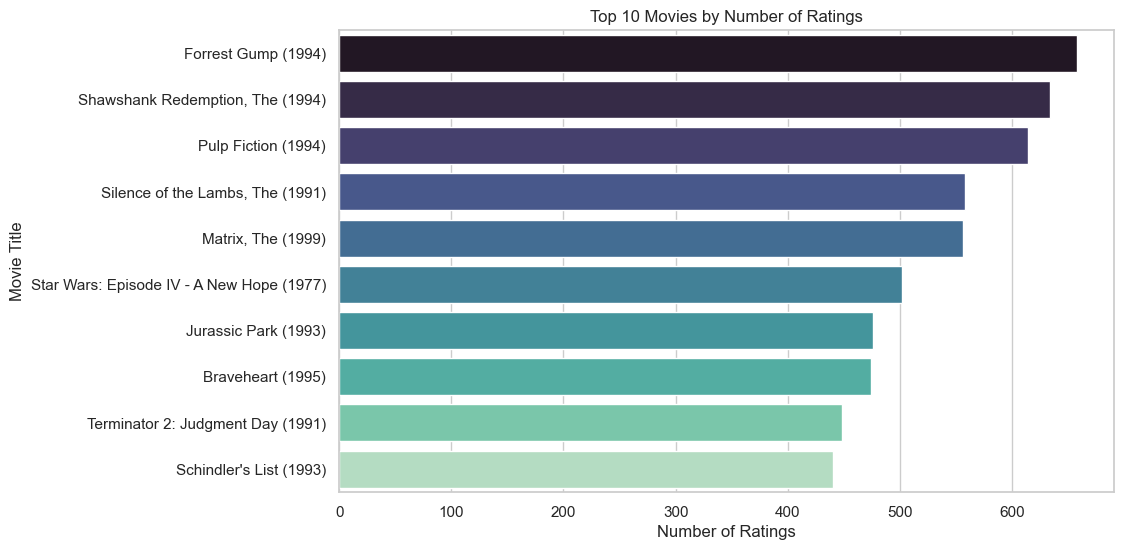

In [16]:
query_top_movies_by_ratings_count = """
SELECT m.title, COUNT(r.rating) AS num_ratings
FROM ratings r
JOIN movies m ON r.movieId = m.movieId
GROUP BY m.movieId
ORDER BY num_ratings DESC
LIMIT 10;
"""
top_movies_by_rating_count_df = pd.read_sql(query_top_movies_by_ratings_count, conn)
plt.figure(figsize=(10, 6))
sns.barplot(x='num_ratings', y='title', data=top_movies_by_rating_count_df, palette="mako")
plt.title("Top 10 Movies by Number of Ratings")
plt.xlabel("Number of Ratings")
plt.ylabel("Movie Title")

### Ratings Time Trends

Text(0, 0.5, 'Number of Ratings')

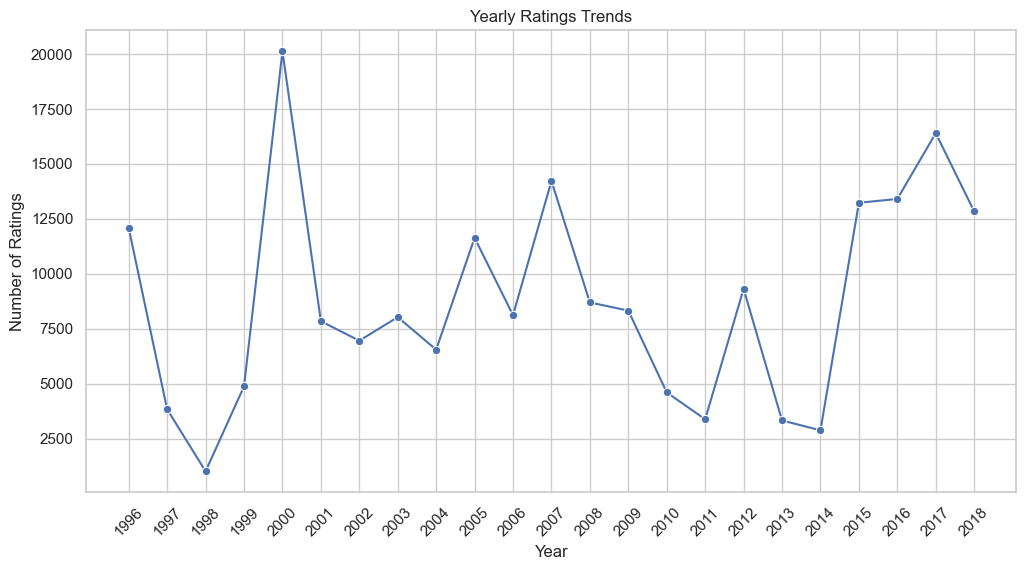

In [19]:
query_ratings_time_trends = """
SELECT DATE_FORMAT(FROM_UNIXTIME(timestamp), '%Y') AS year, COUNT(*) AS num_ratings
FROM ratings
GROUP BY year
ORDER BY year;
"""
ratings_time_trends_df = pd.read_sql(query_ratings_time_trends, conn)
plt.figure(figsize=(12, 6))
sns.lineplot(x='year', y='num_ratings', data=ratings_time_trends_df, marker='o')
plt.xticks(rotation=45)
plt.title("Yearly Ratings Trends")
plt.xlabel("Year")
plt.ylabel("Number of Ratings")

### Most famous Genre

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_8876\3696773926.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='genres', y='num_ratings', data=genre_popularity, palette='viridis')


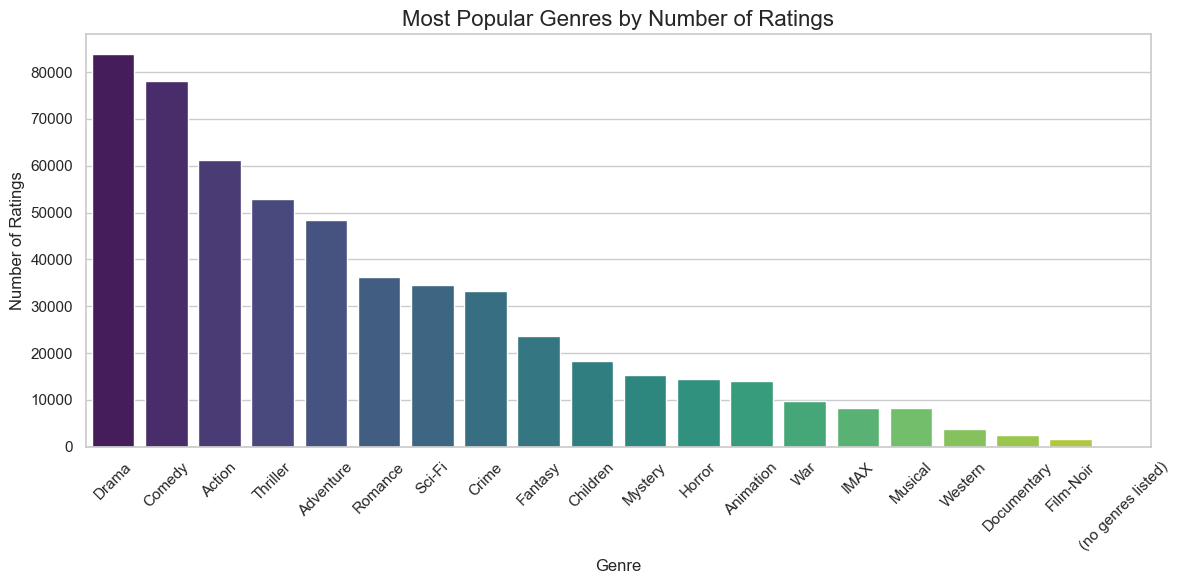

In [25]:
connection = pymysql.connect(**db_settings)
# Query to fetch movies and ratings
query = """
    SELECT m.genres, r.rating
    FROM movies m
    JOIN ratings r ON m.movieId = r.movieId;
"""

# Load data into pandas DataFrame
data = pd.read_sql(query, connection)

# Close the database connection
connection.close()

# Explode genres into separate rows
data['genres'] = data['genres'].str.split('|')
exploded_data = data.explode('genres')

# Group by genre and calculate metrics
genre_popularity = exploded_data.groupby('genres').agg(
    num_ratings=('rating', 'count'),
    avg_rating=('rating', 'mean')
).reset_index()

# Sort genres by number of ratings
genre_popularity.sort_values(by='num_ratings', ascending=False, inplace=True)

plt.figure(figsize=(12, 6))
sns.barplot(x='genres', y='num_ratings', data=genre_popularity, palette='viridis')
plt.title('Most Popular Genres by Number of Ratings', fontsize=16)
plt.xlabel('Genre', fontsize=12)
plt.ylabel('Number of Ratings', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()